In [ ]:
import openai
from prompts.prompts import Tutor_prompt, Classify_prompt
import os
import requests
from langgraph.graph import MessagesState, StateGraph, START, END
from langchain_core.tools import tool
from langgraph.types import Command, interrupt
from langchain_openai import ChatOpenAI
from typing import TypedDict, List, Dict, Any, Optional, Literal
from dotenv import load_dotenv
import json
from utils.web_search import serpapi_search
import logging
from enum import Enum

# Setup logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

load_dotenv()

# Constants
MATH_SOLVER_API = os.getenv('MATH_SOLVER')
MATH_TUTOR_API = os.getenv('MATH_TUTOR')

# Enums for better type safety
class StudentStatus(Enum):
    UNKNOWN = 0
    CORRECT = 1
    INCORRECT = 2

class NodeType(Enum):
    GENERAL_CHAT = "call_general_chat"
    TUTOR = "tutor"
    SOLVER = "solver"
    WEB_SEARCH = "web_search"

# Improved state definition with better typing and validation
class ChatState(TypedDict):
    messages: List[Dict[str, Any]]
    ground_truth: str
    problem: str
    student_solution: str
    student_get_it_right: int
    web_query: str
    confidence_score: Optional[float]  # Added for better decision making
    error_message: Optional[str]  # Added for error handling

# Tools with better error handling
@tool 
def web_search(query: str) -> str:
    """Find information on the web with improved error handling"""
    try:
        if not query or not query.strip():
            return "Error: Empty search query provided"
        
        result = serpapi_search(query)
        logger.info(f"Web search completed for query: {query}")
        return result
    except Exception as e:
        logger.error(f"Web search failed: {str(e)}")
        return f"Error: Could not perform web search - {str(e)}"

@tool
def get_solver(problem: str) -> str:
    """Get solution for a math problem with retry logic"""
    try:
        if not problem or not problem.strip():
            return "Error: Empty problem provided"
        
        if not MATH_SOLVER_API:
            return "Error: Math solver API not configured"
            
        payload = {"prompt": problem}
        response = requests.post(
            MATH_SOLVER_API, 
            json=payload, 
            timeout=30  # Added timeout
        )
        response.raise_for_status()  # Raise exception for bad status codes
        
        result = response.json()
        solution = result.get('response', 'No solution found')
        logger.info(f"Math problem solved successfully")
        return solution
        
    except requests.exceptions.Timeout:
        logger.error("Math solver API timeout")
        return "Error: Math solver service is taking too long to respond"
    except requests.exceptions.RequestException as e:
        logger.error(f"Math solver API error: {str(e)}")
        return f"Error: Could not connect to math solver - {str(e)}"
    except Exception as e:
        logger.error(f"Unexpected error in get_solver: {str(e)}")
        return f"Error: Unexpected error occurred - {str(e)}"

@tool
def get_tutor_response(history_chat: List[Dict[str, Any]], problem: str, ground_truth: str) -> str:
    """Get tutor response with improved dialogue creation"""
    try:
        if not history_chat or not problem or not ground_truth:
            return "Error: Missing required information for tutoring"
        
        if not MATH_TUTOR_API:
            return "Error: Math tutor API not configured"
            
        dialogue = create_dialogue(history_chat[1:])  # Skip system message
        user_prompt = f"""
            Problem: {problem}
            Ground truth solution: {ground_truth}
            Dialogue_history: {dialogue}
        """
        
        payload = {"prompt": user_prompt, "language": "Tiếng Việt"}
        response = requests.post(
            MATH_TUTOR_API, 
            json=payload, 
            timeout=30
        )
        response.raise_for_status()
        
        result = response.json()
        tutor_response = result.get('response', 'No response from tutor')
        logger.info("Tutor response generated successfully")
        return tutor_response
        
    except requests.exceptions.Timeout:
        logger.error("Math tutor API timeout")
        return "Error: Tutor service is taking too long to respond"
    except requests.exceptions.RequestException as e:
        logger.error(f"Math tutor API error: {str(e)}")
        return f"Error: Could not connect to tutor service - {str(e)}"
    except Exception as e:
        logger.error(f"Unexpected error in get_tutor_response: {str(e)}")
        return f"Error: Unexpected error occurred - {str(e)}"

def create_dialogue(history_chat: List[Dict[str, Any]]) -> str:
    """Create dialogue string from chat history with better formatting"""
    if not history_chat:
        return "No previous conversation"
    
    dialogue_parts = []
    for message in history_chat:
        role = message.get('role', 'unknown')
        content = message.get('content', '')
        
        if role == "user":
            dialogue_parts.append(f"Student: {content}")
        elif role == "assistant":
            dialogue_parts.append(f"Teacher: {content}")
        # Skip system messages or unknown roles
    
    return "\n".join(dialogue_parts) if dialogue_parts else "No dialogue history"

# Initialize model with better configuration
def initialize_model():
    """Initialize the chat model with proper configuration"""
    try:
        from langchain.chat_models import init_chat_model
        model = init_chat_model("openai:gpt-4o-mini", temperature=0.4)
        model = model.bind_tools([get_solver, get_tutor_response, web_search])
        return model
    except Exception as e:
        logger.error(f"Failed to initialize model: {str(e)}")
        raise

model = initialize_model()

# Initialize classify client with better error handling
def initialize_classify_client():
    """Initialize OpenAI client for classification"""
    try:
        return openai.OpenAI()
    except Exception as e:
        logger.error(f"Failed to initialize OpenAI client: {str(e)}")
        raise

classify_client = initialize_classify_client()

def identify_intent(state: ChatState) -> ChatState:
    """Identify user intent with improved error handling and state management"""
    try:
        messages = state["messages"]
        if not messages:
            logger.warning("No messages in state")
            return state
        
        problem = state.get('problem', '')
        ground_truth = state.get('ground_truth', '')
        student_solution = state.get('student_solution', '')
        student_get_it_right = state.get('student_get_it_right', 0)
        last_message = messages[-1].get("content", "")
        
        if not last_message:
            logger.warning("Empty last message")
            return state
        
        # Call classification API
        response = classify_client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {"role": "user", "content": Classify_prompt(problem, student_solution, ground_truth, last_message)},
            ],
            timeout=30
        )
        
        result = json.loads(response.choices[0].message.content)
        logger.info(f"Classification result: {result}")
        
        # Update state with extracted information
        state = update_state_from_classification(state, result)
        
        return state
        
    except json.JSONDecodeError as e:
        logger.error(f"Failed to parse classification response: {str(e)}")
        state['error_message'] = "Failed to understand the request"
        return state
    except Exception as e:
        logger.error(f"Error in identify_intent: {str(e)}")
        state['error_message'] = f"Classification error: {str(e)}"
        return state

def update_state_from_classification(state: ChatState, classification_result: Dict[str, Any]) -> ChatState:
    """Update state based on classification results"""
    # Only update if current state is empty and classification provides new info
    if not state.get('problem') and classification_result.get("problem"):
        state['problem'] = classification_result['problem']
    
    if not state.get('student_solution') and classification_result.get('student_solution'):
        state['student_solution'] = classification_result['student_solution']
    
    if state.get('student_get_it_right', 0) == 0 and classification_result.get('student_get_it_right'):
        state['student_get_it_right'] = classification_result['student_get_it_right']
    
    if not state.get('web_query') and classification_result.get('web_query'):
        state['web_query'] = classification_result['web_query']
    
    # Add confidence score if available
    if 'confidence' in classification_result:
        state['confidence_score'] = classification_result['confidence']
    
    return state

def which_tool(state: ChatState) -> Literal["web_search", "call_general_chat", "solver", "tutor"]:
    """Determine which tool to use based on state with improved logic"""
    # Check for errors first
    if state.get('error_message'):
        return NodeType.GENERAL_CHAT.value
    
    # Check for web search request
    if state.get('web_query'):
        return NodeType.WEB_SEARCH.value
    
    # Check for problem without solution
    problem = state.get('problem', '')
    ground_truth = state.get('ground_truth', '')
    student_solution = state.get('student_solution', '')
    student_get_it_right = state.get('student_get_it_right', 0)
    
    # No problem identified yet
    if not problem:
        return NodeType.GENERAL_CHAT.value
    
    # Problem exists but no ground truth solution
    if problem and not ground_truth:
        return NodeType.SOLVER.value
    
    # Problem exists but no student solution
    if problem and not student_solution:
        return NodeType.GENERAL_CHAT.value
    
    # Problem, ground truth, and student solution exist, but student didn't get it right
    if problem and ground_truth and student_solution and student_get_it_right == 0:
        return NodeType.TUTOR.value
    
    # Default to general chat
    return NodeType.GENERAL_CHAT.value

def call_general_chat(state: ChatState) -> ChatState:
    """Handle general chat with better error handling"""
    try:
        messages = state["messages"]
        if not messages:
            logger.warning("No messages for general chat")
            return state
        
        # Check if there's an error message to handle
        if state.get('error_message'):
            error_response = f"I apologize, but I encountered an issue: {state['error_message']}. How can I help you with your math problem?"
            messages.append({"role": "assistant", "content": error_response})
            state['error_message'] = None  # Clear error after handling
        else:
            response = model.invoke(messages)
            messages.append({"role": "assistant", "content": response.content})
        
        state["messages"] = messages
        return state
        
    except Exception as e:
        logger.error(f"Error in call_general_chat: {str(e)}")
        messages = state["messages"]
        messages.append({"role": "assistant", "content": "I'm sorry, I encountered an error. Please try again."})
        state["messages"] = messages
        return state

def web_search_node(state: ChatState) -> ChatState:
    """Handle web search with better error handling"""
    try:
        web_query = state.get('web_query', '')
        if not web_query:
            logger.warning("No web query provided")
            return state
        
        search_result = web_search.invoke({"query": web_query})
        state["messages"].append({"role": "assistant", "content": search_result})
        
        # Clear web query after processing
        state['web_query'] = ''
        
        return state
        
    except Exception as e:
        logger.error(f"Error in web_search_node: {str(e)}")
        error_message = f"I couldn't search for that information. Error: {str(e)}"
        state["messages"].append({"role": "assistant", "content": error_message})
        return state

def solver_node(state: ChatState) -> ChatState:
    """Handle problem solving with better error handling"""
    try:
        problem = state.get('problem', '')
        if not problem:
            logger.warning("No problem to solve")
            return state
        
        ground_truth = get_solver.invoke({"problem": problem})
        
        if ground_truth.startswith("Error:"):
            # Handle solver errors
            state["messages"].append({"role": "assistant", "content": ground_truth})
        else:
            state['ground_truth'] = ground_truth
            logger.info("Problem solved successfully")
        
        return state
        
    except Exception as e:
        logger.error(f"Error in solver_node: {str(e)}")
        error_message = f"I couldn't solve the problem. Error: {str(e)}"
        state["messages"].append({"role": "assistant", "content": error_message})
        return state

def tutor_node(state: ChatState) -> ChatState:
    """Handle tutoring with better error handling"""
    try:
        problem = state.get('problem', '')
        ground_truth = state.get('ground_truth', '')
        messages = state.get('messages', [])
        
        if not all([problem, ground_truth, messages]):
            logger.warning("Missing required information for tutoring")
            return state
        
        response = get_tutor_response.invoke({
            "history_chat": messages,
            "problem": problem, 
            "ground_truth": ground_truth
        })
        
        messages.append({"role": "assistant", "content": response})
        state["messages"] = messages
        
        return state
        
    except Exception as e:
        logger.error(f"Error in tutor_node: {str(e)}")
        error_message = f"I couldn't provide tutoring help. Error: {str(e)}"
        state["messages"].append({"role": "assistant", "content": error_message})
        return state

def construct_agent():
    """Construct the LangGraph agent with improved structure"""
    try:
        workflow = StateGraph(ChatState)

        # Add nodes
        workflow.add_node('identify_intent', identify_intent)
        workflow.add_node('tutor', tutor_node)
        workflow.add_node('solver', solver_node)
        workflow.add_node('call_general_chat', call_general_chat)
        workflow.add_node('web_search', web_search_node)

        # Add conditional edges
        workflow.add_conditional_edges(
            'identify_intent',
            which_tool,
            ['tutor', 'solver', 'call_general_chat', 'web_search']
        )

        # Add edges
        workflow.add_edge(START, 'identify_intent')
        workflow.add_edge('tutor', END) 
        workflow.add_edge('solver', 'identify_intent')  # Go back to identify_intent after solving
        workflow.add_edge('call_general_chat', END) 
        workflow.add_edge('web_search', END)

        # Setup memory
        from langgraph.checkpoint.memory import MemorySaver
        memory = MemorySaver()

        # Compile the workflow
        app = workflow.compile(checkpointer=memory)
        logger.info("Agent constructed successfully")
        return app
        
    except Exception as e:
        logger.error(f"Failed to construct agent: {str(e)}")
        raise

# Helper function to create initial state
def create_initial_state() -> ChatState:
    """Create initial state for the agent"""
    return {
        "messages": [],
        "ground_truth": "",
        "problem": "",
        "student_solution": "",
        "student_get_it_right": 0,
        "web_query": "",
        "confidence_score": None,
        "error_message": None
    }

# Example usage function
def run_agent_example():
    """Example of how to use the agent"""
    agent = construct_agent()
    
    # Create initial state
    initial_state = create_initial_state()
    initial_state["messages"] = [
        {"role": "user", "content": "Giải phương trình x² - 5x + 6 = 0"}
    ]
    
    # Run the agent
    config = {"configurable": {"thread_id": "math_session_1"}}
    result = agent.invoke(initial_state, config)
    
    return result

if __name__ == "__main__":
    # Example usage
    try:
        result = run_agent_example()
        print("Agent result:", result)
    except Exception as e:
        print(f"Error running agent: {e}")

INFO:__main__:Agent constructed successfully
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:__main__:Classification result: {'problem': 'Giải phương trình x² - 5x + 6 = 0', 'student_solution': '', 'student_get_it_right': '', 'web_query': ''}
INFO:__main__:Math problem solved successfully
INFO:__main__:Problem solved successfully
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:__main__:Classification result: {'problem': 'Giải phương trình x² - 5x + 6 = 0', 'student_solution': '', 'student_get_it_right': '', 'web_query': ''}
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Agent result: {'messages': [{'role': 'user', 'content': 'Giải phương trình x² - 5x + 6 = 0'}, {'role': 'assistant', 'content': ''}], 'ground_truth': ' Phương trình đã cho là một phương trình bậc hai có dạng $x^2 - 5x + 6 = 0$.\n\nA. Tìm nghiệm của phương trình.\n\nĐể giải phương trình $x^2 - 5x + 6 = 0$, chúng ta có thể phân tích thành nhân tử. Chúng ta cần tìm hai số nguyên có tích bằng $6$ và có tổng bằng $-5$. Hai số này là $-2$ và $-3$.\n\nDo đó, phương trình có thể được viết lại dưới dạng tích của hai nhân tử.\n\n$(x - 2)(x - 3) = 0$.\n\nPour le trouver les solutions, nous mettons chaque facteur égal à zéro.\n\n$x - 2 = 0$. Giải phép thuật này cho ra $x = 2$.\n\n$x - 3 = 0$. Giải phép thuật này cho ra $x = 3$.\n\nB. Kiểm tra nghiệm.\n\nĐể xác nhận các nghiệm, chúng ta thay mỗi giá trị $x$ vào phương trình ban đầu.\n\nVới $x = 2$:\n$2^2 - 5(2) + 6 = 4 - 10 + 6 = 0$. Điều này là đúng, vậy $x = 2$ là một nghiệm hợp lệ.\n\nVới $x = 3$:\n$3^2 - 5(3) + 6 = 9 - 15 + 6 = 0$. Điều này là đ

In [2]:
def show_graph(graph, xray=False):
    """Display a LangGraph mermaid diagram with fallback rendering.
    
    Handles timeout errors from mermaid.ink by falling back to pyppeteer.
    
    Args:
        graph: The LangGraph object that has a get_graph() method
    """
    from IPython.display import Image
    try:
        # Try the default renderer first
        return Image(graph.get_graph(xray=xray).draw_mermaid_png())
    except Exception as e:
        # Fall back to pyppeteer if the default renderer fails
        import nest_asyncio
        nest_asyncio.apply()
        from langchain_core.runnables.graph import MermaidDrawMethod
        return Image(graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER))

INFO:__main__:Agent constructed successfully


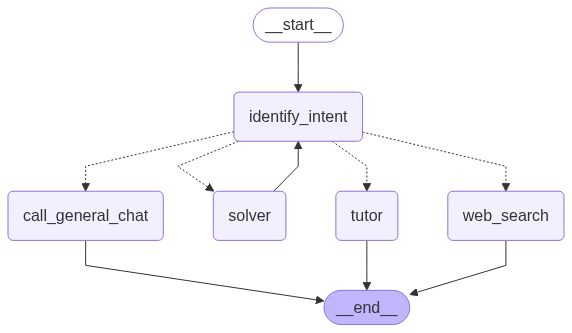

In [3]:
agent = construct_agent()
show_graph(agent)